### Chess.com Data Fetching Functions

This notebook contains functions to interact with the Chess.com API to fetch player and game data. Below is a summary of the functions provided:

### `fetch_player_data(username)`
- **Description**: Retrieves basic profile information for a given Chess.com player.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A dictionary with the player's data if successful.
  - `None` if the request fails.

### `fetch_monthly_games(username, year, month)`
- **Description**: Fetches all games played by a Chess.com player in a specific month and year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `year` (int): The year of the games to fetch.
  - `month` (int): The month of the games to fetch.
- **Returns**:
  - A list of game dictionaries if successful.
  - `None` if the request fails.

### `fetch_all_games(username)`
- **Description**: Fetches all games ever played by a Chess.com player, starting from their account creation date.
- **Arguments**:
  - `username` (str): The username of the player.
- **Returns**:
  - A list of all game dictionaries for the player.
  - An empty list if the player's join date cannot be determined.

### `fetch_all_games_for_current_year(username, game_filter=None)`
- **Description**: Fetches all games played by a Chess.com player in the current year.
- **Arguments**:
  - `username` (str): The username of the player.
  - `game_filter` (function, optional): A function to filter games. Takes a game dictionary as input and returns `True` if the game should be included.
- **Returns**:
  - A list of game dictionaries for the current year.

In [12]:
import re
import requests

def fetch_player_data(username):
    url = f"https://api.chess.com/pub/player/{username}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"  # customize as needed, ensure my request is legit 
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        return response.json()
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

# Example Usage
my_data = fetch_player_data("emazing19")
print(my_data.keys())

'''for key in my_data:
    print(f"{key}: {my_data[key]}")
my_country = my_data['country']

my_data = fetch_player_data("hikaru")
print(my_data.keys())

for key in my_data:
    print(f"{key}: {my_data[key]}")
my_country = my_data['country']'''
#i only want my avatar
#what do i want? 1. their country so I can strip it, if titled, is_streamer

dict_keys(['avatar', 'player_id', '@id', 'url', 'name', 'username', 'followers', 'country', 'last_online', 'joined', 'status', 'is_streamer', 'verified', 'league', 'streaming_platforms'])


'for key in my_data:\n    print(f"{key}: {my_data[key]}")\nmy_country = my_data[\'country\']\n\nmy_data = fetch_player_data("hikaru")\nprint(my_data.keys())\n\nfor key in my_data:\n    print(f"{key}: {my_data[key]}")\nmy_country = my_data[\'country\']'

In [13]:
def fetch_monthly_games(username, year, month):
    url = f"https://api.chess.com/pub/player/{username}/games/{year}/{month:02}"
    headers = {
        "User-Agent": "MyChessApp/1.0 (https://example.com)"
    }
    response = requests.get(url, headers=headers)
    
    if response.status_code != 200:
        print(f"Error: Received status code {response.status_code}")
        print(f"Response content: {response.text}")
        return None
    
    try:
        data = response.json()  # Parse the response JSON
        #print(f"Fetched data: {data}")  # Print the response to inspect its structure
        return data["games"]
    except requests.exceptions.JSONDecodeError:
        print(f"Failed to parse JSON. Status code: {response.status_code}, Content: {response.text}")
        return None

## Future Note: I want to extract your pfp and be able to host a wesbite showing your pfp

In [14]:
def fetch_all_games(username):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    # Get join date and current date
    join_date = datetime.fromtimestamp(player_data["joined"])
    current_date = datetime.now()

    all_games = []
    year, month = join_date.year, join_date.month

    while (year, month) <= (current_date.year, current_date.month):
        #print(f"Fetching games for {year}-{month:02}")
        games = fetch_monthly_games(username, year, month)
        all_games.extend(games)

        # Increment month
        if month == 12:
            year += 1
            month = 1
        else:
            month += 1

    return all_games

def fetch_all_games_for_current_year(username, game_filter=None):
    player_data = fetch_player_data(username)
    if not player_data or "joined" not in player_data:
        print("Could not determine player's join date.")
        return []

    # Get current date
    current_date = datetime.now()

    # Initialize list to store all games
    all_games = []
    
    # Fetch games for the current year
    year = current_date.year
    month = 1  # Start from January

    while month <= current_date.month:
        # Fetch games for the given month
        games = fetch_monthly_games(username, year, month)

        # Apply the game filter if provided
        if game_filter:
            games = [game for game in games if game_filter(game)]

        all_games.extend(games)

        # Increment month
        month += 1

    return all_games

### This function evaluates the positions of a chess game after every move using a chess engine, such as Stockfish. It provides insights into the game by assigning centipawn scores or detecting checkmate situations.


 **Description**: Evaluates the positions of a chess game move by move and returns a list of evaluations (centipawns or mate-in scores).


In [16]:
import chess
import chess.engine

def evaluate_positions(game_moves, engine_path, depth=5, time_limit=0.1):
    """
    Evaluates the positions of a chess game after every move using a chess engine.
    
    Args:
        game_moves (list): A list of moves for a single chess game in standard algebraic notation.
        engine_path (str): Path to the chess engine executable (e.g., '/path/to/stockfish').
        depth (int): Depth of evaluation for the chess engine.
        time_limit (float): Time limit for each move evaluation in seconds (optional, default 2.0 seconds).
    
    Returns:
        list: A list of evaluations after each move (in centipawns).
    """
    # Initialize the chess board for the game
    board = chess.Board()
    
    # Start the chess engine
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        evaluations = []
        
        for move in game_moves:
            # Apply the move to the board
            try:
                board.push_san(move)
            except ValueError as e:
                print(f"Invalid move {move}: {e}")
                break
            
            # Get the evaluation with time control
            info = engine.analyse(board, chess.engine.Limit(time=time_limit))  # Set a time limit for evaluation
            
            # Get the PovScore (from the point of view of the current side to move)
            pov_score = info["score"]
            
            # Access the relative score from the PovScore object
            relative_score = pov_score.relative
            
            # Check if the relative score indicates a checkmate situation
            if relative_score.is_mate():
                eval_cp = f"M in {relative_score.mate()}"
            else:
                # For non-mate situations, use the centipawn evaluation
                eval_cp = relative_score.score(mate_score=10000)  # Centipawn score or checkmate
            
            evaluations.append(eval_cp)
    
    return evaluations


In [17]:
import re
import pandas as pd
from datetime import datetime

import re

def extract_moves_from_pgn(pgn):
    """
    Extracts only chess moves from a PGN string, ignoring move numbers, annotations, and timestamps.
    Ensures that only valid moves containing letters (indicating pieces or files) are included.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        list: A list of chess moves in sequence, including any pawn promotions (e.g., '=Q', '=N').
    """
    # Remove PGN metadata (lines that start with '[')
    pgn_clean = re.sub(r'\[.*?\]\n', '', pgn)

    # Split the PGN into individual words (moves, annotations, timestamps)
    pgn_clean = pgn_clean.split()
    moves = []

    # Iterate through the split components
    for word in pgn_clean:
        # Skip anything that looks like a move number (e.g., '1.', '2.', etc.)
        if word.isdigit() or '.' in word:
            continue
        
        # Skip annotations (like '{[%clk 0:02:54.6]}')
        if word.startswith('{'):
            continue
    
        if word in ['O-O', 'O-O-O']:
            moves.append(word)
        # Handle pawn promotions (e.g., d8=Q, e7=R)
        elif '=' in word:
            moves.append(word)
        # Handle regular moves (e.g., Nc6, exd5), ensure it contains at least one letter
        elif any(c.isalpha() for c in word):
            moves.append(word)

    return moves


def extract_pgn_metadata(pgn):
    """
    Extract metadata from a PGN string.
    
    Args:
        pgn (str): The PGN string containing metadata and moves.
    
    Returns:
        dict: A dictionary containing the metadata fields and their values.
    """
    metadata = {}
    metadata_lines = re.findall(r'\[(\w+)\s+"(.*?)"\]', pgn)
    for key, value in metadata_lines:
        metadata[key] = value
    return metadata

def calculate_time_difference(start_time, end_time):
    """
    Calculate the time difference between two times in HH:MM:SS format.
    
    Args:
        start_time (str): Start time in HH:MM:SS format.
        end_time (str): End time in HH:MM:SS format.
    
    Returns:
        int: Time difference in seconds.
    """
    try:
        fmt = "%H:%M:%S"
        start = datetime.strptime(start_time, fmt)
        end = datetime.strptime(end_time, fmt)
        delta = (end - start).seconds
        return delta
    except Exception:
        return None

'''def extract_moves_and_timestamps(game_data):
    # Regular expression to match move numbers (multi-digit supported) and timestamps
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    # Return the last two pairs (move number, timestamp), if they exist
    return matches[:] if len(matches) >= 2 else matches'''
def extract_moves_and_timestamps(game_data):
    # Regular expression to match White and Black moves with their timestamps
    matches = re.findall(r'(\d+)\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}|(\d+)\.\.\. \S+ \{\[%clk ([0-9:]+(?:\.[0-9]+)?)\]\}', game_data)
    
    # Extract only move numbers and timestamps, ignoring empty results
    white_moves = [(move[0], move[1]) for move in matches if move[0] != '']
    black_moves = [(move[2], move[3]) for move in matches if move[2] != '']

    #print(white_moves)
    #print(black_moves)
    # Return only the move number and the timestamp without any extra information
    return white_moves, black_moves

def format_single_time_control(time_control):
    if '+' in time_control:
        base, increment = time_control.split('+')
    else:
        base, increment = time_control, '0'
    
    minutes = int(base) // 60
    seconds = int(increment)
    return f"{minutes} + {seconds}"
    

def fetch_and_process_game_data(username, engine_path="/opt/homebrew/bin/stockfish"):
    all_games = fetch_all_games_for_current_year(username) ## change to current year if necessary
    game_data = []

    for game in all_games:
        # Extract PGN metadata
        if 'pgn' not in game:
            print(f"Skipping game due to missing 'pgn' (Bughouse?): {game.get('url', 'Unknown URL')}")
            continue  # Skip this game if 'pgn' is missing (these are bughouse games or weird ass games)
            
        pgn = game['pgn']

        time_control = format_single_time_control(game['time_control'])
        metadata = extract_pgn_metadata(pgn)

        date = metadata.get('Date', None)
        start_time = metadata.get('StartTime', None)
        end_time = metadata.get('EndTime', None)
        link = metadata.get('Link', None)
        eco = metadata.get('ECOUrl', None)
        time_spent = calculate_time_difference(start_time, end_time)
        moves = extract_moves_from_pgn(pgn)

        # Example usage
        
        w_metamoves, b_metamoves = extract_moves_and_timestamps(pgn)
        
        data = {
            'url': game['url'],
            'pgn': pgn,
            'moves': moves,
            'date': date,
            'start_time': start_time,
            'end_time': end_time,
            'time_spent': time_spent,
            'link': link,
            'time_control': time_control,
            'time_class': game['time_class'],
            'rated': game['rated'],
            'tcn': game['tcn'],
            'uuid': game['uuid'],
            'initial_setup': game['initial_setup'],
            'fen': game['fen'], #this is the position
            'rules': game['rules'],
            'white_username': game['white']['username'],
            'white_rating': game['white']['rating'],
            'white_result': game['white']['result'],
            'white_metamoves': w_metamoves,
            'black_username': game['black']['username'],
            'black_rating': game['black']['rating'],
            'black_result': game['black']['result'],
            'black_metamoves': b_metamoves,
            'eco': eco
        }
        # Append the extracted data as a dictionary to the list
        game_data.append(data)

    # Convert the list of dictionaries into a DataFrame
    df = pd.DataFrame(game_data)
    
    return df

Hello, this is the main function!
['3 + 0' '1 + 0' '10 + 0' '3 + 2' '5 + 0' '5 + 2']
Execution time: 1.99 seconds


In [11]:
print("in construction")
'''"""
import pandas as pd
import numpy as np
import chess
import chess.engine
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# Function to get Stockfish evaluation for a given position
def get_position_evaluation(board, engine_path='/opt/homebrew/bin/stockfish'):
    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:
        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position
        score = info['score'].relative.score(mate_score=10000)
        return score if score is not None else 0

# Convert algebraic notation to UCI format
def move_to_uci(move, board):
    """
    Convert a move in algebraic notation to UCI format.
    Assumes the move is valid for the current board state.
    
    Args:
        move (str): The move in algebraic notation (e.g., 'd4', 'Nc6').
        board (chess.Board): The current board state.
    
    Returns:
        str: The move in UCI format (e.g., 'e2e4', 'Ng1f3').
    """
    try:
        # Try to parse the move using SAN (Standard Algebraic Notation)
        chess_move = board.push_san(move)  # This pushes the move to the board
        uci_move = chess_move.uci()  # Convert the chess.Move object to UCI format
        return uci_move
    except ValueError:
        raise ValueError(f"Invalid move: {move}")

# Function to process the moves and generate features
def process_game(pgn, engine_path='/opt/homebrew/bin/stockfish'):
    moves = extract_moves_from_pgn(pgn)  # Ensure this function works as expected
    board = chess.Board()  # Start from the initial position
    print(board.legal_moves)
    
    features = []
    

    for move in moves:
        try:
            print(f"Current board:\n{board}")  # Print the current board state
            print(f"Trying move: {move}")
            
            
            # Ensure the move is legal before applying it
            if move in board.legal_moves:
                print(f"Move {move} is legal.")
                
                # Convert the move to UCI format and apply it
                uci_move = move_to_uci(move, board)
                print(f"UCI move: {uci_move}")  # Debugging: Check the UCI move output
                
                # Get the evaluation of the position after the move
                evaluation = get_position_evaluation(board, engine_path)
                features.append(evaluation)
            else:
                print(f"Move {move} is illegal in the current position.")
        
        except ValueError as e:
            print(f"Error: ValueError - {e}")
        except Exception as e:
            print(f"Unexpected error: {e}")
            print(f"Move: {move}")  # This helps to know which move caused the issue.
            print(f"Type of move: {type(move)}")  # Check the type of 'move'
        
    return features


# Assuming you have a DataFrame `df` containing your games
# Extract features and labels (e.g., win or loss)
X = []
y = []

for idx, row in df.iterrows():
    pgn = row['pgn']
    outcome = row['white_result']  # Assume 'outcome' is 1 for win, 0 for loss (or other encoding)
    if outcome == 'win':
        outcome = 1
    else:
        outcome = 0

    # Extract features from the game
    features = process_game(pgn)
    X.append(features)
    y.append(outcome)

# Convert lists into numpy arrays for machine learning
X = np.array(X)
y = np.array(y)

# Step 4: Train the model
# Flatten the features to make them compatible for training
X_flattened = X.reshape(X.shape[0], -1)  # Flattening the moves (each move's evaluation)
X_train, X_test, y_train, y_test = train_test_split(X_flattened, y, test_size=0.2, random_state=42)

# Create and train a Random Forest classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

# Step 5: Evaluate the model
y_pred = clf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f'Model Accuracy: {accuracy * 100:.2f}%')
"""'''

in construction


'"""\nimport pandas as pd\nimport numpy as np\nimport chess\nimport chess.engine\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import train_test_split\nfrom sklearn.metrics import accuracy_score\n\n# Function to get Stockfish evaluation for a given position\ndef get_position_evaluation(board, engine_path=\'/opt/homebrew/bin/stockfish\'):\n    with chess.engine.SimpleEngine.popen_uci(engine_path) as engine:\n        info = engine.analyse(board, chess.engine.Limit(time=0.1))  # 0.1s time per position\n        score = info[\'score\'].relative.score(mate_score=10000)\n        return score if score is not None else 0\n\n# Convert algebraic notation to UCI format\ndef move_to_uci(move, board):\n    """\n    Convert a move in algebraic notation to UCI format.\n    Assumes the move is valid for the current board state.\n    \n    Args:\n        move (str): The move in algebraic notation (e.g., \'d4\', \'Nc6\').\n        board (chess.Board): The current boar

### Cleaning

In [24]:
import pandas as pd

def clean_dataframe(df, username):
    """
    Cleans and processes a chess DataFrame.

    Parameters:
        df (pd.DataFrame): The original DataFrame to clean.
        username (str): The username of the player to analyze.

    Returns:
        pd.DataFrame: The cleaned and processed DataFrame.
    """
    # Make a copy of the DataFrame
    cleaned_df = df.copy()

    # Clean and process the 'eco' column
    cleaned_df['eco'] = cleaned_df['eco'].str.split('/openings/').str[1]

    def truncate_eco(name):
        if name is None:
            return 'No Opening'
        keywords = ["Defense", "Gambit", "Opening", "Game", "Attack", "System"]
        first_position = len(name)  # Initialize with the maximum possible index
        keyword_found = None  # To store the keyword that caused truncation
        for keyword in keywords:
            pos = name.find(keyword)
            if pos != -1 and pos < first_position:  # Find the earliest occurrence
                first_position = pos
                keyword_found = keyword
        # If a keyword was found, truncate up to the end of the keyword
        return name[:first_position + len(keyword_found)] if keyword_found else name

    cleaned_df['eco'] = cleaned_df['eco'].apply(truncate_eco)

    # Initialize new columns with None
    columns_to_initialize = [
        'my_username', 'my_rating', 'my_result', 'my_win_or_lose', 'my_metamoves',
        'opp_username', 'opp_rating', 'opp_result', 'opp_metamoves'
    ]
    for column in columns_to_initialize:
        cleaned_df[column] = None

    # Loop through and assign values based on the condition
    for index, row in cleaned_df.iterrows():
        if row['white_username'] == username:
            cleaned_df.at[index, 'my_username'] = row['white_username']
            cleaned_df.at[index, 'my_rating'] = row['white_rating']
            cleaned_df.at[index, 'my_result'] = row['white_result']
            cleaned_df.at[index, 'my_color'] = 'white'
            cleaned_df.at[index, 'my_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['black_username']
            cleaned_df.at[index, 'opp_rating'] = row['black_rating']
            cleaned_df.at[index, 'opp_result'] = row['black_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['white_result'] == 'win' else 'draw' if row['white_result'] in ['draw', 'stalemate', 'repetition', 'insufficient'] else 'lose'

        elif row['black_username'] == username:
            cleaned_df.at[index, 'my_username'] = row['black_username']
            cleaned_df.at[index, 'my_rating'] = row['black_rating']
            cleaned_df.at[index, 'my_result'] = row['black_result']
            cleaned_df.at[index, 'my_color'] = 'black'
            cleaned_df.at[index, 'my_metamoves'] = row['black_metamoves']
            cleaned_df.at[index, 'opp_username'] = row['white_username']
            cleaned_df.at[index, 'opp_rating'] = row['white_rating']
            cleaned_df.at[index, 'opp_result'] = row['white_result']
            cleaned_df.at[index, 'opp_metamoves'] = row['white_metamoves']
            cleaned_df.at[index, 'my_win_or_lose'] = 'win' if row['black_result'] == 'win' else 'draw' if row['black_result'] in ['draw', 'stalemate', 'repetition', 'insufficient'] else 'lose'

    def time_string_to_seconds_with_fraction(time_str):
        # Split the string into hours, minutes, and seconds
        h, m, s = map(float, time_str.split(':'))
        # Calculate total seconds, including fractional seconds
        return h * 3600 + m * 60 + s

    def convert_time_class_to_seconds(time_class):
        # Extract the part before the '+', convert to integer, and multiply by 60 to get seconds
        base_minutes = int(time_class.split('+')[0].strip())
        return base_minutes * 60

    # Calculate time-related columns
    cleaned_df['my_time_left'] = cleaned_df['my_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]))
    cleaned_df['opp_time_left'] = cleaned_df['opp_metamoves'].apply(lambda x: time_string_to_seconds_with_fraction(x[-1][1]))
    cleaned_df['my_num_moves'] = cleaned_df['my_metamoves'].apply(len)

    cleaned_df['my_time_left_ratio'] = cleaned_df.apply(
        lambda row: row['my_time_left'] / convert_time_class_to_seconds(row['time_control']),
        axis=1
    )

    cleaned_df['opp_time_left_ratio'] = cleaned_df.apply(
        lambda row: row['opp_time_left'] / convert_time_class_to_seconds(row['time_control']),
        axis=1
    )

    return cleaned_df
    # Print unique 'eco' values for debugging
    print(cleaned_df['eco'].unique())

    return cleaned_df


import time

def main():
    print("Hello, this is the main function!")
    start_time = time.time()

    
    # Example usage
    username = "emazing19"
    #username = "EdwardL903"
    df = fetch_and_process_game_data(username)
    cleaned_df = clean_dataframe(df, username)
    print(cleaned_df)
    
    end_time = time.time()
    duration = end_time - start_time
    print(f"Execution time: {duration:.2f} seconds")

# Boilerplate to run main
if __name__ == "__main__":
    main()



Hello, this is the main function!
                                               url  \
0      https://www.chess.com/game/live/97867214065   
1      https://www.chess.com/game/live/97869615913   
2      https://www.chess.com/game/live/97869704473   
3      https://www.chess.com/game/live/98032800385   
4      https://www.chess.com/game/live/98032912375   
...                                            ...   
1088  https://www.chess.com/game/live/129016357831   
1089  https://www.chess.com/game/live/129102143487   
1090  https://www.chess.com/game/live/129102163613   
1091  https://www.chess.com/game/live/129102180799   
1092  https://www.chess.com/game/live/129102756383   

                                                    pgn  \
0     [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   
1     [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   
2     [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   
3     [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...   
4     [Event "Live Che

In [9]:
cleaned_df['eco']
print(cleaned_df.columns.tolist())

#print(cleaned_df['moves'])

def split_moves(row):
    moves = row['moves']
    if row['my_color'] == 'white':
        my_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
        opp_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
    else:
        my_moves = moves[1::2]  # Take even positions (1-indexed: 1, 3, 5, ...)
        opp_moves = moves[::2]  # Take odd positions (0-indexed: 0, 2, 4, ...)
    return my_moves, opp_moves

# Apply the function and assign new columns
cleaned_df[['my_moves', 'opp_moves']] = cleaned_df.apply(
    lambda row: pd.Series(split_moves(row)), axis=1
)

#print(cleaned_df['opp_moves'])

def track_castling(my_moves):
    if 'O-O-O' in my_moves:
        return 'queenside'
    elif 'O-O' in my_moves:
        return 'kingside'
    else:
        return 'none'

cleaned_df['my_castling'] = cleaned_df['my_moves'].apply(track_castling)
cleaned_df['opp_castling'] = cleaned_df['opp_moves'].apply(track_castling)


print(cleaned_df[['my_castling', 'opp_castling']])

# Count the occurrences of each type of castling
castling_counts = cleaned_df['my_castling'].value_counts()

# Store the counts in variables
kingside_castles = castling_counts.get('kingside', 0)
queenside_castles = castling_counts.get('queenside', 0)
no_castles = castling_counts.get('none', 0)

# Print the results
print(f"Kingside castles: {kingside_castles}")
print(f"Queenside castles: {queenside_castles}")
print(f"No castles: {no_castles}")

result_counts = cleaned_df['my_result'].value_counts()
print(f"Result Counts: {result_counts}")
total_games = len(cleaned_df)
total_win = result_counts.get('win', 0)
total_checkmated = result_counts.get('checkmated', 0)
total_timeout = result_counts.get('timeout', 0)
total_timevsinsufficient = result_counts.get('timevsinsufficient', 0)
total_resigned = result_counts.get('resigned', 0)
total_stalemate = result_counts.get('stalemate', 0)
total_repetition = result_counts.get('repetition', 0)
total_abandoned = result_counts.get('abandoned', 0)
total_insufficient = result_counts.get('insufficient', 0)

# Calculate the ratios for each category
win_ratio = total_win / total_games
checkmated_ratio = total_checkmated / total_games
timeout_ratio = total_timeout / total_games
timevsinsufficient_ratio = total_timevsinsufficient / total_games
resigned_ratio = total_resigned / total_games
stalemate_ratio = total_stalemate / total_games
repetition_ratio = total_repetition / total_games
abandoned_ratio = total_abandoned / total_games
insufficient_ratio = total_insufficient / total_games

# Print the ratios
print(f"Win ratio: {win_ratio:.2f}")
print(f"Checkmated ratio: {checkmated_ratio:.2f}")
print(f"Timeout ratio: {timeout_ratio:.2f}")
print(f"Time vs Insufficient ratio: {timevsinsufficient_ratio:.2f}")
print(f"Resigned ratio: {resigned_ratio:.2f}")
print(f"Stalemate ratio: {stalemate_ratio:.2f}")
print(f"Repetition ratio: {repetition_ratio:.2f}")
print(f"Abandoned ratio: {abandoned_ratio:.2f}")
print(f"Insufficient ratio: {insufficient_ratio:.2f}")

print(total_games)
print(win_ratio)
print(total_win)

['url', 'pgn', 'moves', 'date', 'start_time', 'end_time', 'time_spent', 'link', 'time_control', 'time_class', 'rated', 'tcn', 'uuid', 'initial_setup', 'fen', 'rules', 'white_username', 'white_rating', 'white_result', 'white_metamoves', 'black_username', 'black_rating', 'black_result', 'black_metamoves', 'eco', 'my_username', 'my_rating', 'my_result', 'my_win_or_lose', 'my_metamoves', 'opp_username', 'opp_rating', 'opp_result', 'opp_metamoves', 'my_color', 'my_time_left', 'opp_time_left', 'my_num_moves', 'my_time_left_ratio', 'opp_time_left_ratio']
     my_castling opp_castling
0       kingside         none
1      queenside     kingside
2       kingside     kingside
3       kingside     kingside
4       kingside     kingside
...          ...          ...
1088   queenside     kingside
1089    kingside         none
1090   queenside     kingside
1091        none    queenside
1092    kingside         none

[1093 rows x 2 columns]
Kingside castles: 332
Queenside castles: 219
No castles: 542


In [10]:
def count_promotions(my_moves):
    """Counts the number of promotions in the given list of moves."""
    return sum('=' in move for move in my_moves)

def count_en_passant(my_moves):
    """Counts the number of en passant occurrences in the given list of moves."""
    return sum('e.p.' in move for move in my_moves)

cleaned_df['en_passant_count'] = cleaned_df['my_moves'].apply(count_en_passant)
cleaned_df['promotion_count'] = cleaned_df['my_moves'].apply(count_promotions)

# Sum the total occurrences of en passant and promotions
total_en_passant = cleaned_df['en_passant_count'].sum()
total_promotions = cleaned_df['promotion_count'].sum()

# Print the results
print(f"Total En Passant occurrences: {total_en_passant}")
print(f"Total Promotions occurrences: {total_promotions}")


#BUG so basically enpassants are like exf3 so i have to track enpassants much more complicated  


Total En Passant occurrences: 0
Total Promotions occurrences: 66


In [11]:


import pandas as pd
import matplotlib.pyplot as plt

# Assuming `cleaned_df` is your DataFrame
# Replace with your actual DataFrame loading if necessary

# Calculate the win rate for each opening (eco)
win_rates = (
    cleaned_df.groupby('eco')['my_win_or_lose']
    .apply(lambda x: (x == 'win').sum() / len(x))  # Proportion of wins
    .reset_index(name='win_rate')  # Rename column for clarity
)

# Count the number of games played for each opening
games_played = cleaned_df['eco'].value_counts().reset_index()
games_played.columns = ['eco', 'Games_Played']  # Rename columns for clarity

# Merge win rate and games played into a single DataFrame
openings_stats = win_rates.merge(games_played, on='eco')

# Sort by the number of games played
most_played_openings = openings_stats.sort_values(by='Games_Played', ascending=False)
most_played_openings_top5 = most_played_openings.head()
print(most_played_openings_top5)

# 2. Win/Loss/Draw percentages
total_games = len(cleaned_df)
win_percentage = (cleaned_df['my_win_or_lose'] == 'win').mean() * 100
loss_percentage = (cleaned_df['my_win_or_lose'] == 'lose').mean() * 100
draw_percentage = (cleaned_df['my_win_or_lose'] == 'draw').mean() * 100

# 3. Elo progression
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])  # Ensure date is datetime
elo_progression = cleaned_df.groupby('date')['my_rating'].mean()

# 4. Longest winning and losing streaks
def longest_streak(results, target):
    streak = max((len(list(g)) for k, g in groupby(results) if k == target), default=0)
    return streak

from itertools import groupby
winning_streak = longest_streak(cleaned_df['my_win_or_lose'], 'win')
losing_streak = longest_streak(cleaned_df['my_win_or_lose'], 'lose')

# 5. Quickest checkmate delivered
cleaned_df['num_moves'] = cleaned_df['moves'].apply(len)
quickest_win = cleaned_df.loc[(cleaned_df['my_win_or_lose'] == 'win') & (cleaned_df['num_moves'].idxmin())]

# 6. Total games played
total_games = len(cleaned_df)

# 7. Total hours spent playing chess
total_time_spent = cleaned_df['time_spent'].sum() / 3600  # Convert seconds to hours

# 8. Favorite time control
favorite_time_control = cleaned_df['time_control'].mode()[0]

# 9. Best game by rating difference
cleaned_df['rating_diff'] = cleaned_df['my_rating'] - cleaned_df['opp_rating']
best_game = cleaned_df.loc[(cleaned_df['my_win_or_lose'] == 'win') & (cleaned_df['rating_diff'].idxmax())]

# Displaying results
print("Most-played Openings:")
print(most_played_openings.head())

print("\nWin/Loss/Draw Percentages:")
print(f"Win: {win_percentage:.2f}%, Loss: {loss_percentage:.2f}%, Draw: {draw_percentage:.2f}%")

print("\nLongest Winning Streak:", winning_streak)
print("Longest Losing Streak:", losing_streak)

print("\nQuickest Checkmate Delivered:")
print(quickest_win)

print("\nTotal Games Played:", total_games)
print("Total Hours Spent Playing Chess:", total_time_spent)

print("\nFavorite Time Control:", favorite_time_control)

print("\nBest Game by Rating Difference:")
print(best_game)


# Longest game: Find the game with the maximum number of moves
longest_game = cleaned_df.loc[cleaned_df['num_moves'] == cleaned_df['num_moves'].max()]

# Longest game: Find the game with the maximum number of moves
longest_timed_game = cleaned_df.loc[cleaned_df['time_spent'] == cleaned_df['time_spent'].max()]

# Highest-rated win: Find the highest-rated win by opponent's rating
highest_rated_win = cleaned_df.loc[
    (cleaned_df['my_win_or_lose'] == 'win') & (cleaned_df['opp_rating'] == cleaned_df['opp_rating'].max())
]


# Display the results
print("Quickest Win:")
print(quickest_win[['date', 'moves', 'my_rating', 'opp_rating', 'num_moves', 'link']])
print("\nLongest Moves Game:")
print(longest_game[['date', 'moves', 'my_rating', 'opp_rating', 'num_moves', 'link']])
print("\nLongest Timed Game:")
print(longest_timed_game[['date', 'moves', 'my_rating', 'opp_rating', 'num_moves', 'time_spent', 'link']])
print("\nHighest-Rated Win:")
print(highest_rated_win[['date', 'moves', 'my_rating', 'opp_rating', 'num_moves', 'link']])

# Step 1: Count how many times each opponent appears
most_played_opponent = cleaned_df['opp_username'].value_counts().reset_index()
most_played_opponent.columns = ['Opponent', 'Games_Played']

# Step 2: Display the most played opponent
print("\nMost Played Opponent:")
print(most_played_opponent.head())  # Display top 5 opponents

# Optional: If you want to display the top opponent overall:
top_opponent = most_played_opponent.iloc[0]
print(f"\nTop Opponent: {top_opponent['Opponent']} with {top_opponent['Games_Played']} games")




                     eco  win_rate  Games_Played
36         Queens-Gambit  0.496124           258
37   Queens-Pawn-Opening  0.502793           179
40  Scandinavian-Defense  0.437500           176
14        Englund-Gambit  0.527273            55
43          Slav-Defense  0.533333            45
Most-played Openings:
                     eco  win_rate  Games_Played
36         Queens-Gambit  0.496124           258
37   Queens-Pawn-Opening  0.502793           179
40  Scandinavian-Defense  0.437500           176
14        Englund-Gambit  0.527273            55
43          Slav-Defense  0.533333            45

Win/Loss/Draw Percentages:
Win: 46.48%, Loss: 51.14%, Draw: 2.38%

Longest Winning Streak: 6
Longest Losing Streak: 8

Quickest Checkmate Delivered:
                                               url  \
1      https://www.chess.com/game/live/97869615913   
5      https://www.chess.com/game/live/98032936271   
7      https://www.chess.com/game/live/98034109477   
10     https://www.chess

In [27]:
filtered_df = cleaned_df[cleaned_df['my_time_left'] >= 0.0]
filtered_df = filtered_df[filtered_df['my_time_left'] <= 20.0]

# Print the value counts for the filtered values
#print(filtered_df['my_time_left'].value_counts().sort_index())
print(filtered_df.groupby(['my_time_left', 'my_win_or_lose', 'my_result']).size().sort_index())
## Good under pressure?

# Filter for rows where 'my_win_or_lose' is 'win' and 'my_time_left' is between 0.1 and 3
filtered_wins = filtered_df[
    (filtered_df['my_win_or_lose'] == 'win') &
    (filtered_df['my_time_left'] >= 0.1) &
    (filtered_df['my_time_left'] <= 20)
]

# Group by 'my_time_left' and 'my_win_or_lose', then count occurrences
print(filtered_wins.groupby(['my_time_left', 'my_win_or_lose', 'link']).size().sort_index())

cleaned_df.to_csv('emazing19.csv', index=False)

my_time_left  my_win_or_lose  my_result         
0.1           lose            timeout               42
                              timevsinsufficient     2
              win             win                    1
0.2           lose            checkmated             2
                              timeout               19
                                                    ..
19.4          win             win                    1
19.6          win             win                    1
19.7          lose            checkmated             1
19.9          lose            checkmated             1
20.0          draw            repetition             1
Length: 333, dtype: int64
my_time_left  my_win_or_lose  link                                        
0.1           win             https://www.chess.com/game/live/106286215199    1
0.2           win             https://www.chess.com/game/live/101884489465    1
                              https://www.chess.com/game/live/103614135917    1
     

In [13]:
print(cleaned_df['moves'])

0       [d4, d5, c4, dxc4, e3, e5, Bxc4, exd4, Qxd4, Q...
1       [d4, e6, c4, d5, e4, dxe4, f3, exf3, Qxf3, Nf6...
2       [d4, d5, c4, Nf6, Nf3, dxc4, e3, c5, Bxc4, e6,...
3       [d4, d5, c4, Bf5, b3, Bxb1, Rxb1, dxc4, e3, cx...
4       [d4, d5, c4, dxc4, e3, e6, Bxc4, Nf6, Nc3, Bb4...
                              ...                        
1088    [d4, e6, c4, Bb4+, Bd2, Bxd2+, Nxd2, Qf6, Ngf3...
1089    [e4, d5, exd5, Qxd5, Nf3, Nc6, Nc3, Qd8, Bc4, ...
1090    [d4, g6, c4, Bg7, e3, Nf6, Nf3, d6, Nc3, O-O, ...
1091    [e4, d5, f4, e6, e5, Bc5, Nf3, Nc6, c3, h5, d4...
1092    [d4, e6, c3, c5, e3, cxd4, exd4, Qf6, Bd3, g5,...
Name: moves, Length: 1093, dtype: object


In [14]:
# Plotting Elo progression
#elo_progression.plot(title="Elo Progression Over Time", xlabel="Date", ylabel="Rating")
#plt.show()

In [15]:
'''# Rating progression over time
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])
cleaned_df.sort_values('date', inplace=True)

plt.plot(cleaned_df['date'], cleaned_df['my_rating'], marker='o', color='green')
plt.title("ELO Rating Progression")
plt.ylabel("Rating")
plt.xlabel("Date")
plt.grid()
plt.show()'''

'# Rating progression over time\ncleaned_df[\'date\'] = pd.to_datetime(cleaned_df[\'date\'])\ncleaned_df.sort_values(\'date\', inplace=True)\n\nplt.plot(cleaned_df[\'date\'], cleaned_df[\'my_rating\'], marker=\'o\', color=\'green\')\nplt.title("ELO Rating Progression")\nplt.ylabel("Rating")\nplt.xlabel("Date")\nplt.grid()\nplt.show()'

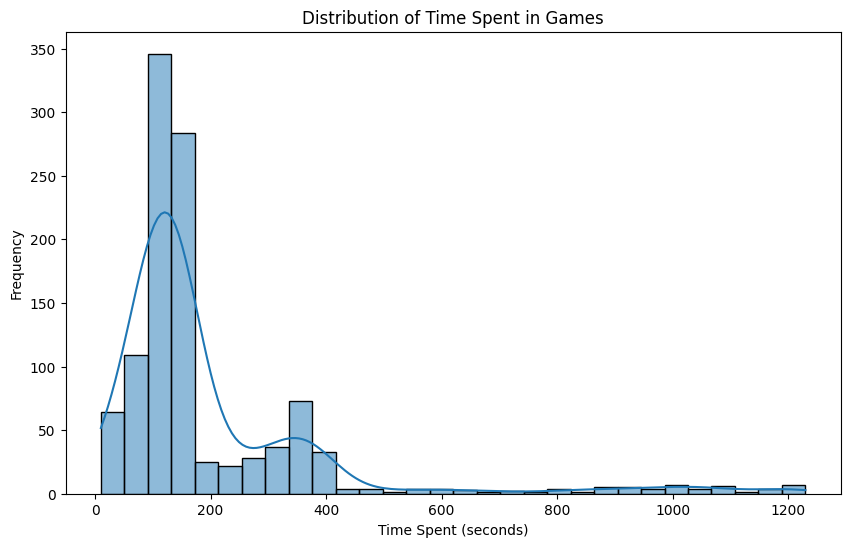

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram of 'time_spent'
plt.figure(figsize=(10, 6))
sns.histplot(df['time_spent'], bins=30, kde=True)
plt.title('Distribution of Time Spent in Games')
plt.xlabel('Time Spent (seconds)')
plt.ylabel('Frequency')
plt.show()

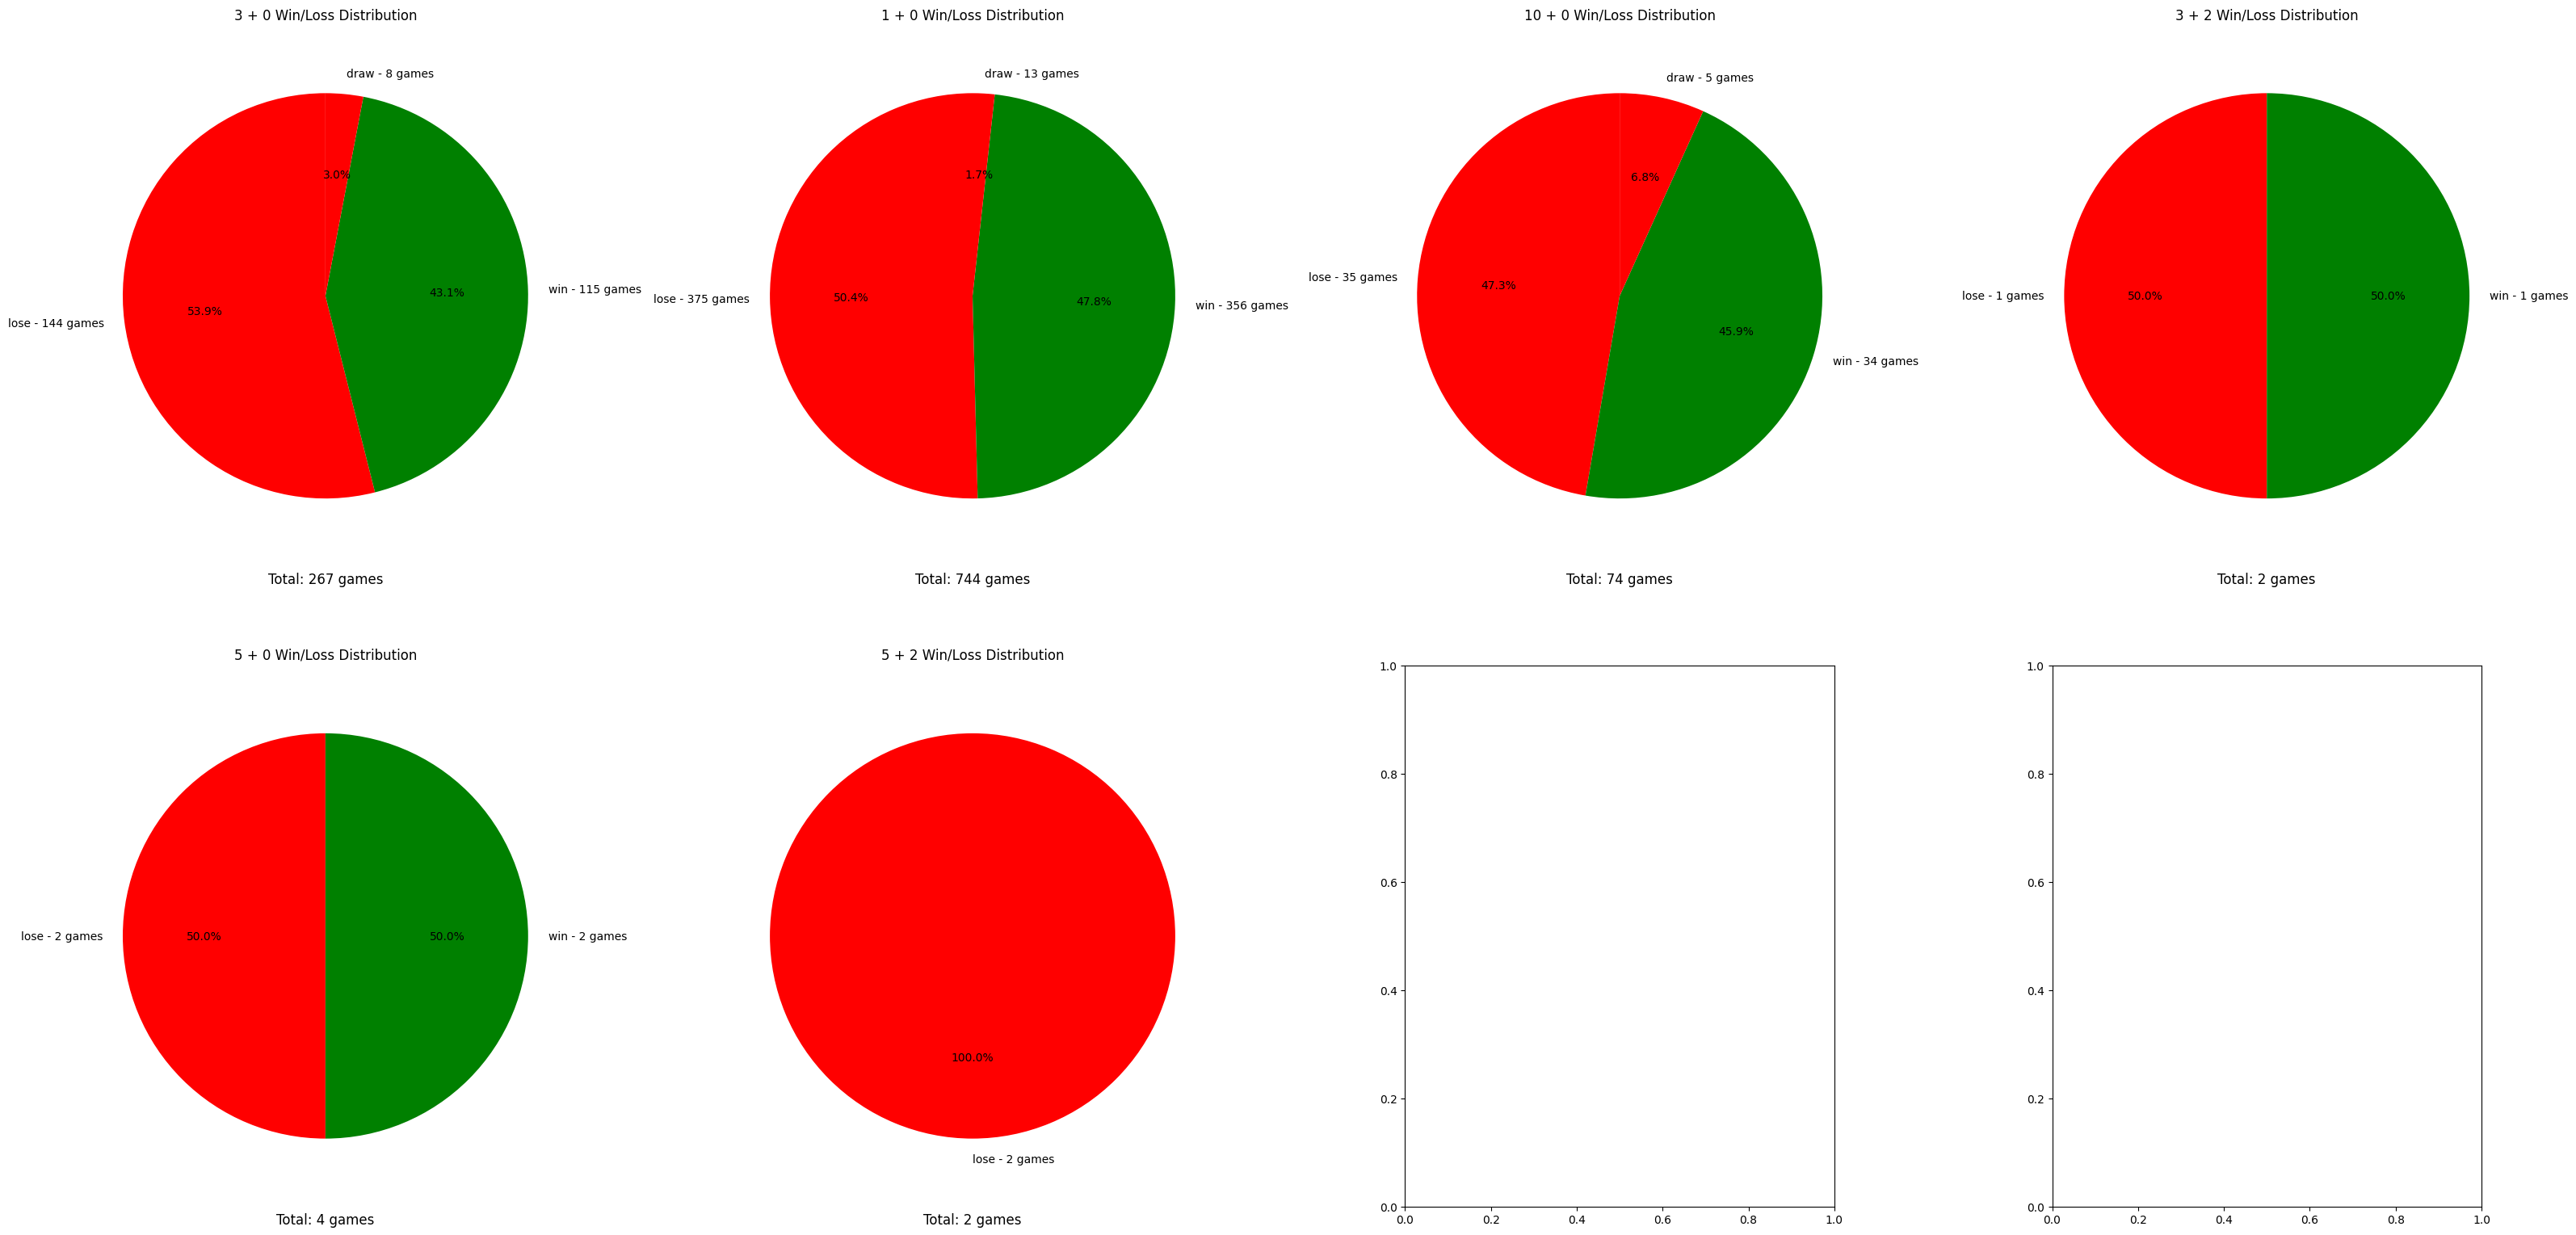

In [17]:
import matplotlib.pyplot as plt

# Get unique time_controls
time_controls = cleaned_df['time_control'].unique()

# Set up the number of columns (e.g., 3 columns for each row) and rows
n_cols = 4  # Set number of columns to 3 (you can adjust this)
n_rows = (len(time_controls) + n_cols - 1) // n_cols  # Calculate number of rows dynamically

# Set up the subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, n_rows * 8))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the axes array to make indexing easier

# Loop through each time_control and plot the pie chart
for i, time_control in enumerate(time_controls):
    # Filter the DataFrame for the current time_control
    time_control_data = cleaned_df[cleaned_df['time_control'] == time_control]
    
    # Count the occurrences of 'my_win_or_lost' for that time_control
    win_loss_counts = time_control_data['my_win_or_lose'].value_counts()
    
    # Define custom colors (green for win, red for loss)
    colors = ['green' if result == 'win' else 'red' for result in win_loss_counts.index]
    
    # Create labels with both count and percentage
    total_games = len(time_control_data)
    labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
    # Add total games count at the bottom of the chart
    label_text = f'Total: {total_games} games'
    
    # Plot a pie chart for the current time_control
    ax = axes[i]  # Use the i-th axis in the flattened axes array
    wedges, texts, autotexts = ax.pie(win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    
    # Set title
    ax.set_title(f'{time_control} Win/Loss Distribution')
    
    # Adjust the label text position for the pie chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    
    # Add total games label below the pie chart
    ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

# Adjust layout for better spacing between charts
plt.tight_layout()

# Display the pie charts
plt.show()

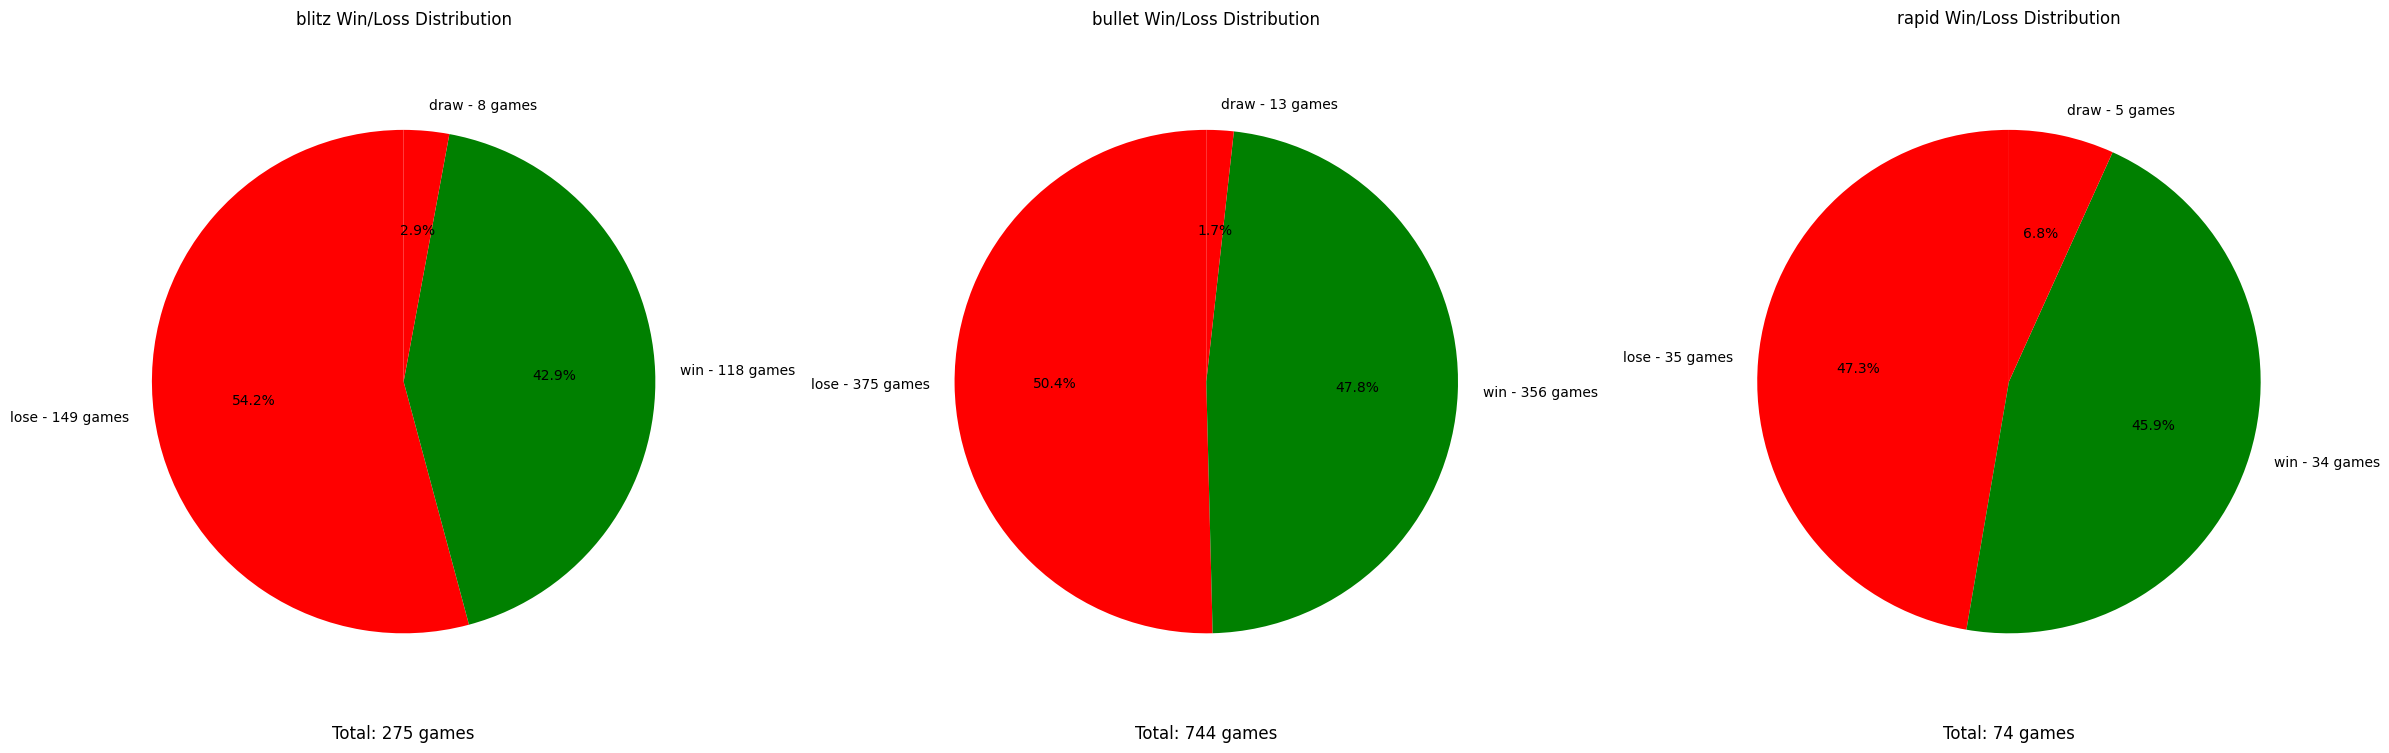

In [18]:
import matplotlib.pyplot as plt

# Get unique time_classes
time_classes = cleaned_df['time_class'].unique()

# Set up the number of rows and columns for the subplots
n_cols = len(time_classes)  # Create one subplot per time_class
n_rows = 1  # All in one row
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 8, 8))  # Adjust figsize as needed

# Loop through each time_class and plot the pie chart
for i, time_class in enumerate(time_classes):
    # Filter the DataFrame for the current time_class
    time_class_data = cleaned_df[cleaned_df['time_class'] == time_class]
    
    # Count the occurrences of 'my_win_or_lost' for that time_class
    win_loss_counts = time_class_data['my_win_or_lose'].value_counts()
    
    # Define custom colors (green for win, red for loss)
    colors = ['green' if result == 'win' else 'red' for result in win_loss_counts.index]
    
    # Create labels with both count and percentage
    total_games = len(time_class_data)
    labels = [f'{result} - {count} games' for result, count in zip(win_loss_counts.index, win_loss_counts)]
    # Add total games count at the bottom of the chart
    label_text = f'Total: {total_games} games'
    
    # Plot a pie chart for the current time_class
    ax = axes[i] if n_cols > 1 else axes  # Adjust axes indexing based on the number of columns
    wedges, texts, autotexts = ax.pie(win_loss_counts, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors)
    
    # Set title  
    ax.set_title(f'{time_class} Win/Loss Distribution')
    
    # Adjust the label text position for the pie chart
    ax.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
    3
    # Add total games label below the pie chart
    ax.text(0, -1.4, label_text, ha='center', va='center', fontsize=12, color='black')

# Adjust layout for better spacing between charts
plt.tight_layout()

# Display the pie charts side by side
plt.show()

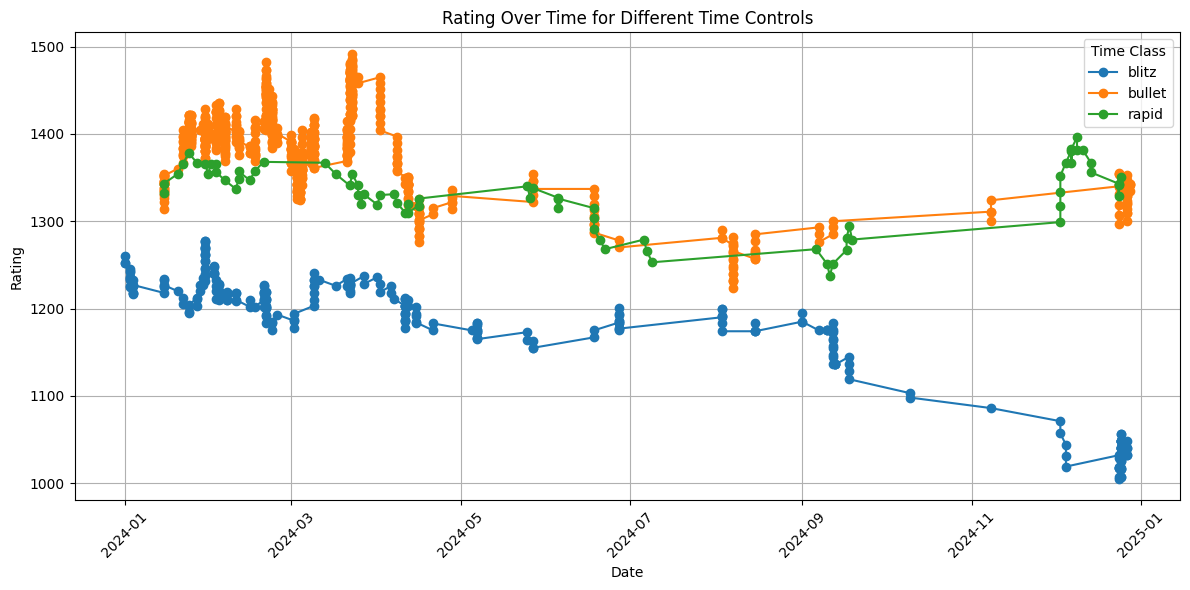

In [19]:
import matplotlib.pyplot as plt

# Ensure 'date' is in datetime format
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

# Filter rows where 'my_rating' exists
rating_data = cleaned_df[~cleaned_df['my_rating'].isna()]

# Get unique time_classes
time_classes = rating_data['time_class'].unique()

# Plot rating over time for each time_class
plt.figure(figsize=(12, 6))

for time_class in time_classes:
    # Filter data for the current time_class
    time_class_data = rating_data[rating_data['time_class'] == time_class]
    
    # Plot rating over time for the current time_class
    plt.plot(time_class_data['date'], time_class_data['my_rating'], marker='o', linestyle='-', label=time_class)

# Customize the plot
plt.title('Rating Over Time for Different Time Controls')
plt.xlabel('Date')
plt.ylabel('Rating')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(title='Time Class')

# Display the plot
plt.tight_layout()
plt.show()



/var/folders/39/n8p80q7s1b13_khp67kt_dlw0000gn/T/ipykernel_69525/2624375213.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  cleaned_df['start_time'] = pd.to_datetime(cleaned_df['start_time'], utc=True).dt.tz_convert(est)


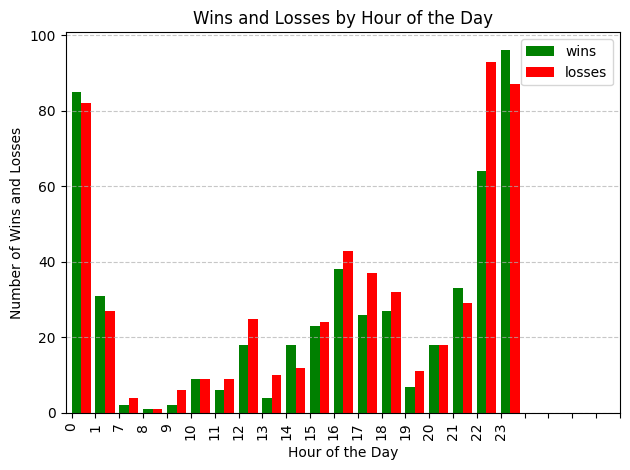

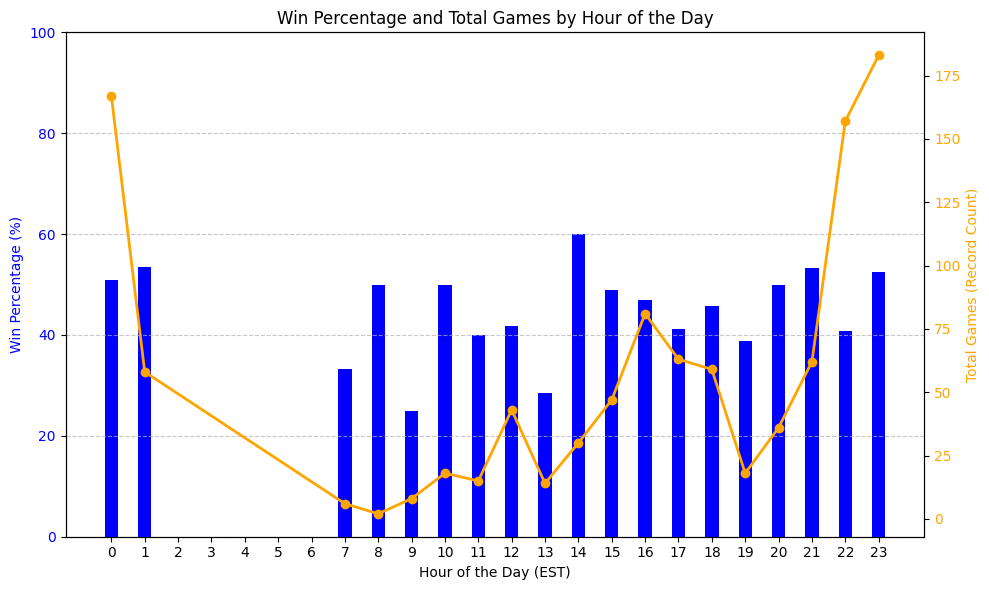

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

import pytz

# Convert 'start_time' from UTC to EST
utc = pytz.utc
est = pytz.timezone("US/Eastern")


# Ensure 'start_time' is in datetime format
cleaned_df['start_time'] = pd.to_datetime(cleaned_df['start_time'], utc=True).dt.tz_convert(est)


# Filter rows for both wins and losses
wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()

# Extract the hour from the 'start_time' column
wins_data['hour'] = wins_data['start_time'].dt.hour
losses_data['hour'] = losses_data['start_time'].dt.hour

# Group by hour and count the wins and losses
hourly_wins = wins_data.groupby('hour').size()
hourly_losses = losses_data.groupby('hour').size()

# Combine the wins and losses into a single DataFrame for easier plotting
hourly_counts = pd.DataFrame({
    'wins': hourly_wins,
    'losses': hourly_losses
}).fillna(0)  # Fill missing values with 0 (some hours may have no wins or losses)

# Plot the side-by-side bar chart
ax = hourly_counts.plot(kind='bar', width=0.8, color=['green', 'red'], position=0)

# Customize the plot
plt.title('Wins and Losses by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Wins and Losses')
plt.xticks(range(0, 24))  # Show every hour on the x-axis
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()


# Calculate total games and win percentages for each hour
hourly_totals = hourly_wins.add(hourly_losses, fill_value=0)
hourly_win_percentage = (hourly_wins / hourly_totals) * 100

# Create the plot with dual axes
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot the win percentage on the first axis as a bar chart
ax1.bar(hourly_win_percentage.index, hourly_win_percentage, width=0.4, color='blue', label='Win Percentage')
ax1.set_xlabel('Hour of the Day (EST)')
ax1.set_ylabel('Win Percentage (%)', color='blue')
ax1.set_ylim(0, 100)  # Percentage ranges from 0 to 100
ax1.tick_params(axis='y', labelcolor='blue')
ax1.set_xticks(range(0, 24))  # Show every hour on the x-axis
ax1.grid(True, axis='y', linestyle='--', alpha=0.7)

# Create a second axis to plot the total games (record count) as a line chart
ax2 = ax1.twinx()
ax2.plot(hourly_totals.index, hourly_totals, color='orange', marker='o', label='Total Games', linewidth=2)
ax2.set_ylabel('Total Games (Record Count)', color='orange')
ax2.tick_params(axis='y', labelcolor='orange')

# Add a title and display the plot
plt.title('Win Percentage and Total Games by Hour of the Day')
fig.tight_layout()  # Ensure everything fits without overlap

# Show the plot
plt.show()

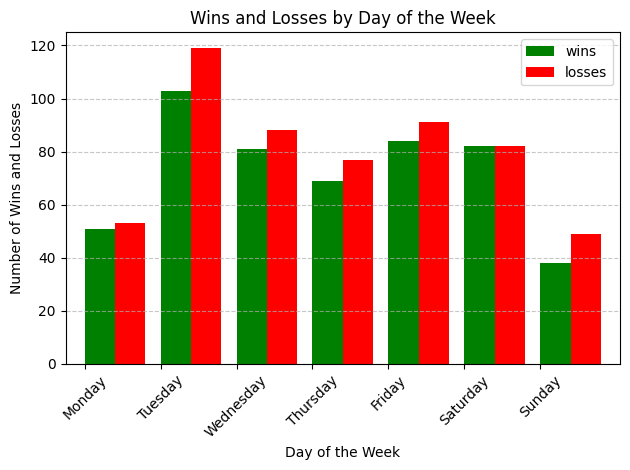

In [21]:
import matplotlib.pyplot as plt
import pandas as pd

# Ensure 'start_time' is in datetime format
cleaned_df['date'] = pd.to_datetime(cleaned_df['date'])

# Filter rows for both wins and losses
wins_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'win'].copy()
losses_data = cleaned_df[cleaned_df['my_win_or_lose'] == 'lose'].copy()

# Extract the day of the week from the 'start_time' column
wins_data['day_of_week'] = wins_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')
losses_data['day_of_week'] = losses_data['date'].dt.day_name()  # Get day name (e.g., 'Monday')

# Group by day of the week and count the wins and losses
hourly_wins = wins_data.groupby('day_of_week').size()
hourly_losses = losses_data.groupby('day_of_week').size()

# Reorder days of the week to ensure proper ordering in the plot
days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# Create a DataFrame combining wins and losses
hourly_counts = pd.DataFrame({
    'wins': hourly_wins,
    'losses': hourly_losses
}).fillna(0)  # Fill missing values with 0 (some days may have no wins or losses)

# Reorder the rows based on the days of the week to ensure the correct order
hourly_counts = hourly_counts.reindex(days_order)

# Plot the side-by-side bar chart
ax = hourly_counts.plot(kind='bar', width=0.8, color=['green', 'red'], position=0)

# Customize the plot
plt.title('Wins and Losses by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Wins and Losses')
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.grid(True, axis='y', linestyle='--', alpha=0.7)

# Display the plot
plt.tight_layout()
plt.show()

In [22]:
print(cleaned_df['eco'].unique())

['Queens-Gambit' 'Queens-Pawn-Opening' 'Scandinavian-Defense'
 'Reti-Opening' 'English-Opening' 'Mieses-Opening' 'Indian-Game'
 'Englund-Gambit' 'Kings-Gambit' 'Kings-Fianchetto-Opening'
 'Modern-Defense' 'Nimzowitsch-Larsen-Attack' 'Van-t-Kruijs-Opening'
 'Old-Benoni-Defense' 'Saragossa-Opening' 'Caro-Kann-Defense'
 'Slav-Defense' 'Birds-Opening' 'Vienna-Game' 'Kings-Pawn-Opening'
 'French-Defense' 'Anderssen-Opening' 'Philidor-Defense' 'Bishops-Opening'
 'Nimzowitsch-Defense' 'Grob-Opening' 'Budapest-Gambit' 'Petrovs-Defense'
 'Old-Indian-Defense' 'Kings-Indian-Defense' 'Barnes-Opening' 'The-Cow'
 'Center-Game' 'Italian-Game' 'Dutch-Defense' 'Pirc-Defense'
 'Sicilian-Defense' 'Semi-Slav-Defense' 'Kings-Indian-Attack'
 'Alekhines-Defense' 'Polish-Opening' 'Benoni-Defense' 'Clemenz-Opening'
 'Four-Knights-Game' 'Colle-System' 'Van-Geet-Opening' 'Kadas-Opening'
 'English-Defense' 'Ware-Opening']


In [23]:
cleaned_df['pgn'].head()

0    [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
1    [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
2    [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
3    [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
4    [Event "Live Chess"]\n[Site "Chess.com"]\n[Dat...
Name: pgn, dtype: object

In [24]:
# Things to Include

In [25]:
# How many Queen Promotions you have (and other promotions?)
# How many en passants you have done
# Win and Loss ratio being white vs black
# Biggest Upset and Biggest Reverse Upset
# Brilliant Moves Finder

In [ ]:
# Are you a fair loser? how do u lose